<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/14_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнеее задание: Июльский курс (2020). Pro. Занятие 14
##Сегментация текста
## Верхошинская Катерина Викторовна

## **LIGHT**

### Задание:
1. Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке
2. Возьмите “лучшую” архитектуру и проведите несколько экспериментов, меняя гиперпараметры выбранной архитектуры.
3. Напишите ваши выводы


In [ ]:
!pip install pymorphy2 # установка лемматизатора pymorphy2

     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 8.2MB 13.5MB/s 


In [ ]:
import numpy as np # Библиотека для работы с массивами данных
from tensorflow.keras.models import Model, load_model # Импортируем модель, метод загрузки предобученной сети 
import re # Импортируем для работы со строками
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
# Импортируем слои для сеток
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D 
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose, Lambda, LSTM, Flatten, GlobalAveragePooling1D
from tensorflow.keras import backend as K # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы 
from tensorflow.keras import utils # Импортируем для работы с категориальными данными 
from google.colab import files # Импортируем для работы с файлами
import matplotlib.pyplot as plt # Импортируем для отрисовки графиков
from gensim.models import word2vec # Импортируем gensim 
import os # Импортируем для работы с файловой системой
import pandas as pd # И мпортируем для работы с DataFrame
import pymorphy2 # Импортируем для работы с леммами
import time # Импортируем для подсчета времени 
import random
from sys import getsizeof
from keras.utils import plot_model # удобный график для визуализации архитектуры модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='loss on train')
        plt.plot(ep, self.history['val_loss'], label='loss on test')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные 
  text = f.read() #Записываем прочитанный текст в переменную 
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова

# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = [] # Список для тегов
  indexes = [] # Здесь будут лежать индексы
 
  for agreement in tok_agreem: # Проходимся по каждому договору-списку
    tag_place = [0, 0, 0, 0, 0, 0] # Создаем вектор [0,0,0,0,0,0]
    for ex in agreement: # Проходимся по каждому слову договора
        if ex in tags_index: # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex) # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0: # Проверяем, чтобы тег действительно был
            if place[0][0]<6: # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1    # Поэтому ставим 1
            else: 
              tag_place[place[0][0] - 6] = 0  # Остальные теги закрывающие, так что меняем на ноль
        else:          
          tags01.append(tag_place.copy()) # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном 
          indexes.append(ex) # Докидываем индекс слова в список индексов

  return indexes, tags01

# Получение списка слов из индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x] # Вытаскиваем по каждому ключу в список
  return words # Возвращаем полученный текст

# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длину текста
  index = 0 # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

In [ ]:
def dice_coef(y_true, y_pred):
    return K.mean(y_true*y_pred + (1 - y_true)*(1 - y_pred))

In [ ]:
# Функция, выводящая точность распознавания каждой категории отдельно
def recognizeSet(tagI, pred, length, value):
  total=0
  tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
  for j in range(6): # общее количество тегов
    correct=0
    for i in range(len(tagI)): # проходимся по каждому списку списка тегов
      for k in range(length): # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int): # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1 
    print("Сеть распознала категорию '%s' на %.2f%%" % (tags[j], 100*correct/(len(tagI)*length)))
    total += 100 * correct / (len(tagI)*length)
  print("Cредняя точность %.2f%%" % (total/6))

#### Подготовка данных

In [ ]:
%%time
directory = '/content/drive/My Drive/Colab Notebooks/Базы/Договора432/'
agreements = [] # Список, в который запишем все наши договоры
for filename in os.listdir(directory): # Проходим по всем файлам в директории договоров
    txt = readText(directory + filename) # Читаем текст договора
    if txt != '': # Если текст не пустой
        agreements.append(readText(directory + filename))
words = [] # Здесь будут храниться все договора в виде списка слов
print("Токенизация...")
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): # Проходимся по всем договорам
    words.append(text2Words(agreements[i])) # Преобразуем очередной договор в список слов и добавляем в words
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

random.shuffle(words)
wordsToTest = words[-30:] # Возьмем 30 текстов для финальной проверки обученной нейронной сети 
words = words[:-30] 

tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer.word_index.items(): #Преобразуем полученный список 
    clean_voc[item[0]] = item[1]

tok_agreem = tokenizer.texts_to_sequences(words)

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

xData, yData = get01XSamples(tok_agreem, tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300

xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов

modelGENSIM = word2vec.Word2Vec(xTrain, size=embeddingSize, window=10, min_count=1, workers=10, iter=10)
xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

Токенизация...
На преобразование ушло: 155.43 с.
Индексы тегов: [ 12 340  23  29 115 273  13 353  24  28 114 265]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 4min 53s, sys: 7.49 s, total: 5min
Wall time: 5min 30s


In [ ]:
# Проверка что число открывающихся тэгов равно числу закрывающихся.
counts = {}
for con in tok_agreem:
    for i in con:
        if i in tags_index:
            tag = tokenizer.index_word[i]
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1

for i in range(1, 7):
    print ("<s%d>: %d, </s%d>: %d" % (i, counts['<s%d>' % i], i , counts['</s%d>' % i]))

<s1>: 4301, </s1>: 4281
<s2>: 205, </s2>: 201
<s3>: 2429, </s3>: 2426
<s4>: 2015, </s4>: 2017
<s5>: 690, </s5>: 690
<s6>: 278, </s6>: 288


#### **1.Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке**



Попробуем применить архитектуру Трансформер с собственным эмбеддингом.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Implement multi head self attention as a Keras layer
"""

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions



In [ ]:
xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
pageSize = xLen
num_classes = 6
vocSize = len(tokenizer.index_word.items()) + 1
print(vocSize)

x_train = np.array(getSetFromIndexes(xData, xLen, step))
y_train = np.array(getSetFromIndexes(yData, xLen, step))
x_train.shape, y_train.shape

5626


((12954, 256), (12954, 256, 6))

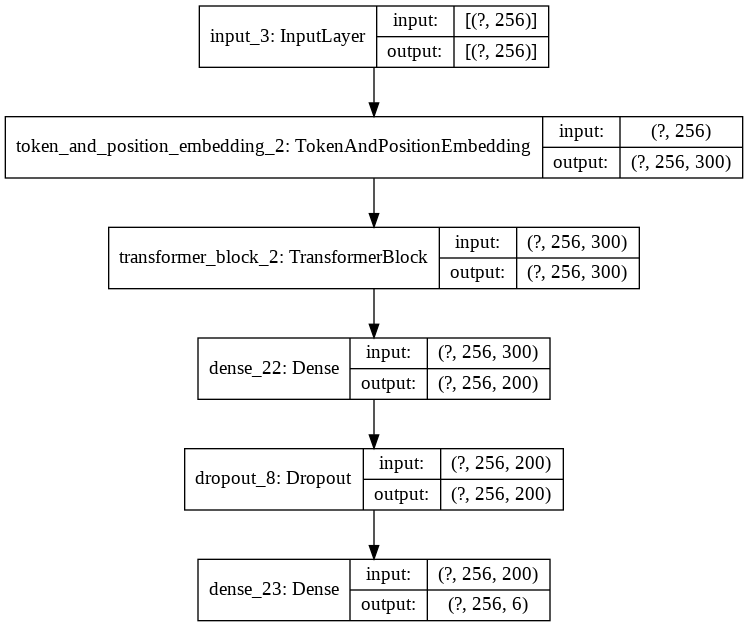

In [ ]:
num_heads = 3  # Number of attention heads
ff_dim = 600  # Hidden layer size in feed forward network inside transformer

inp = Input(shape=(pageSize,))
x = TokenAndPositionEmbedding(pageSize, vocSize, embeddingSize)(inp)
x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x)
x = Dense(200, activation="relu")(x)
x = Dropout(0.1)(x)
out = Dense(num_classes, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer=Adam(0.0025), loss='categorical_crossentropy', metrics=[dice_coef])
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:
lh = LearnHistory()

Epoch 1/25
1037/1037 [==============================] - 38s 37ms/step - loss: 0.6911 - dice_coef: 0.7721 - val_loss: 0.6559 - val_dice_coef: 0.8314
Epoch 2/25
1037/1037 [==============================] - 38s 36ms/step - loss: 0.4585 - dice_coef: 0.8502 - val_loss: 0.7536 - val_dice_coef: 0.8496
Epoch 3/25
1037/1037 [==============================] - 37s 35ms/step - loss: 0.3772 - dice_coef: 0.8710 - val_loss: 0.8428 - val_dice_coef: 0.8536
Epoch 4/25
1037/1037 [==============================] - 38s 36ms/step - loss: 0.3277 - dice_coef: 0.8852 - val_loss: 0.9684 - val_dice_coef: 0.8589
Epoch 5/25
1037/1037 [==============================] - 37s 35ms/step - loss: 0.2963 - dice_coef: 0.8952 - val_loss: 1.1422 - val_dice_coef: 0.8674
Epoch 6/25
1037/1037 [==============================] - 37s 36ms/step - loss: 0.2739 - dice_coef: 0.9019 - val_loss: 1.0514 - val_dice_coef: 0.8606
Epoch 7/25
1037/1037 [==============================] - 37s 35ms/step - loss: 0.2589 - dice_coef: 0.9077 - val_l

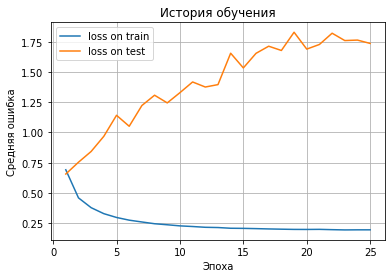

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size=10, validation_split=0.2)
lh.append(history)
lh.plot()

In [ ]:
# Подготовим тестовые данные:
tok_agreem2 = tokenizer.texts_to_sequences(wordsToTest)

xData2, yData2 = get01XSamples(tok_agreem2, tags_index)
x_test = np.array(getSetFromIndexes(xData2, xLen, step))
y_test = np.array(getSetFromIndexes(yData2, xLen, step))
x_test.shape, y_test.shape

((1171, 256), (1171, 256, 6))

In [ ]:
score = model.evaluate(x_test, y_test)
score

37/37 [==============================] - 0s 13ms/step - loss: 2.1412 - dice_coef: 0.8600


[2.1412100791931152, 0.8599520921707153]

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.9)

Сеть распознала категорию 'S1' на 60.52%
Сеть распознала категорию 'S2' на 97.16%
Сеть распознала категорию 'S3' на 83.49%
Сеть распознала категорию 'S4' на 87.46%
Сеть распознала категорию 'S5' на 94.76%
Сеть распознала категорию 'S6' на 98.61%
Cредняя точность 87.00%


**Выводы:**  данная архитектура показала точность **val_dice_coef: 0.8719** на последней эпохе и среднюю точность распознования на тестовой выборке 87.00%, что говорит о хорошей работе сети и её эффективности для подобных задач. 

#### **2.Возьмите “лучшую” архитектуру и проведите несколько экспериментов, меняя гиперпараметры выбранной архитектуры.**



Для того чтобы выбрать "лучшую" архитектуру, проведем ряд экспериментов с разными сетями

##### Conv1D

In [ ]:
# Функция для создания линейной cnonv1d-сети

def create_Conv1d(xLen, embeddingSize): 
  text_input_layer = Input((xLen,embeddingSize)) 
  text_layer = Conv1D(32, 3, padding='same',activation='relu')(text_input_layer)
  text_layer = Conv1D(32, 3, padding='same',activation='relu')(text_layer)
  text_layer = Conv1D(32, 3, padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(yTrainGENSIM.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)
  model = Model(text_input_layer, text_layer)

  model.compile(optimizer=Adadelta(),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
  return model

In [ ]:
model_conv1d = create_Conv1d(xLen, embeddingSize) # Создаем простую сеть

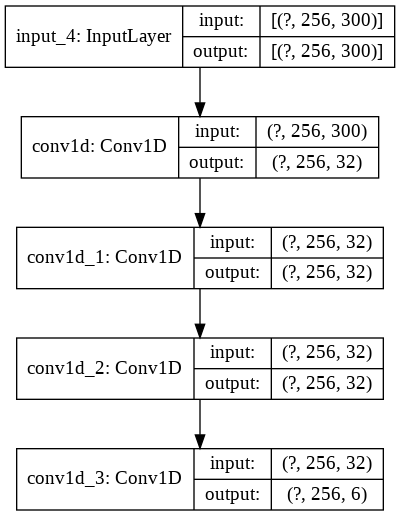

In [ ]:
plot_model(model_conv1d, to_file='model_conv1d.png', show_shapes=True)

In [ ]:
history = model_conv1d.fit(xTrainGENSIM, yTrainGENSIM, epochs=25, batch_size=200, validation_split = 0.2)

Epoch 1/25
52/52 [==============================] - 3s 49ms/step - loss: 1.3103 - dice_coef: 0.4929 - val_loss: 1.3064 - val_dice_coef: 0.4924
Epoch 2/25
52/52 [==============================] - 2s 43ms/step - loss: 1.3044 - dice_coef: 0.4929 - val_loss: 1.3006 - val_dice_coef: 0.4924
Epoch 3/25
52/52 [==============================] - 2s 44ms/step - loss: 1.2985 - dice_coef: 0.4929 - val_loss: 1.2947 - val_dice_coef: 0.4924
Epoch 4/25
52/52 [==============================] - 2s 46ms/step - loss: 1.2926 - dice_coef: 0.4929 - val_loss: 1.2889 - val_dice_coef: 0.4925
Epoch 5/25
52/52 [==============================] - 2s 46ms/step - loss: 1.2867 - dice_coef: 0.4930 - val_loss: 1.2832 - val_dice_coef: 0.4927
Epoch 6/25
52/52 [==============================] - 2s 46ms/step - loss: 1.2809 - dice_coef: 0.4932 - val_loss: 1.2774 - val_dice_coef: 0.4929
Epoch 7/25
52/52 [==============================] - 2s 46ms/step - loss: 1.2751 - dice_coef: 0.4934 - val_loss: 1.2717 - val_dice_coef: 0.4931

##### PSPnet

In [ ]:
# Функция для создания PSPnet-сети
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape)

    # Block 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

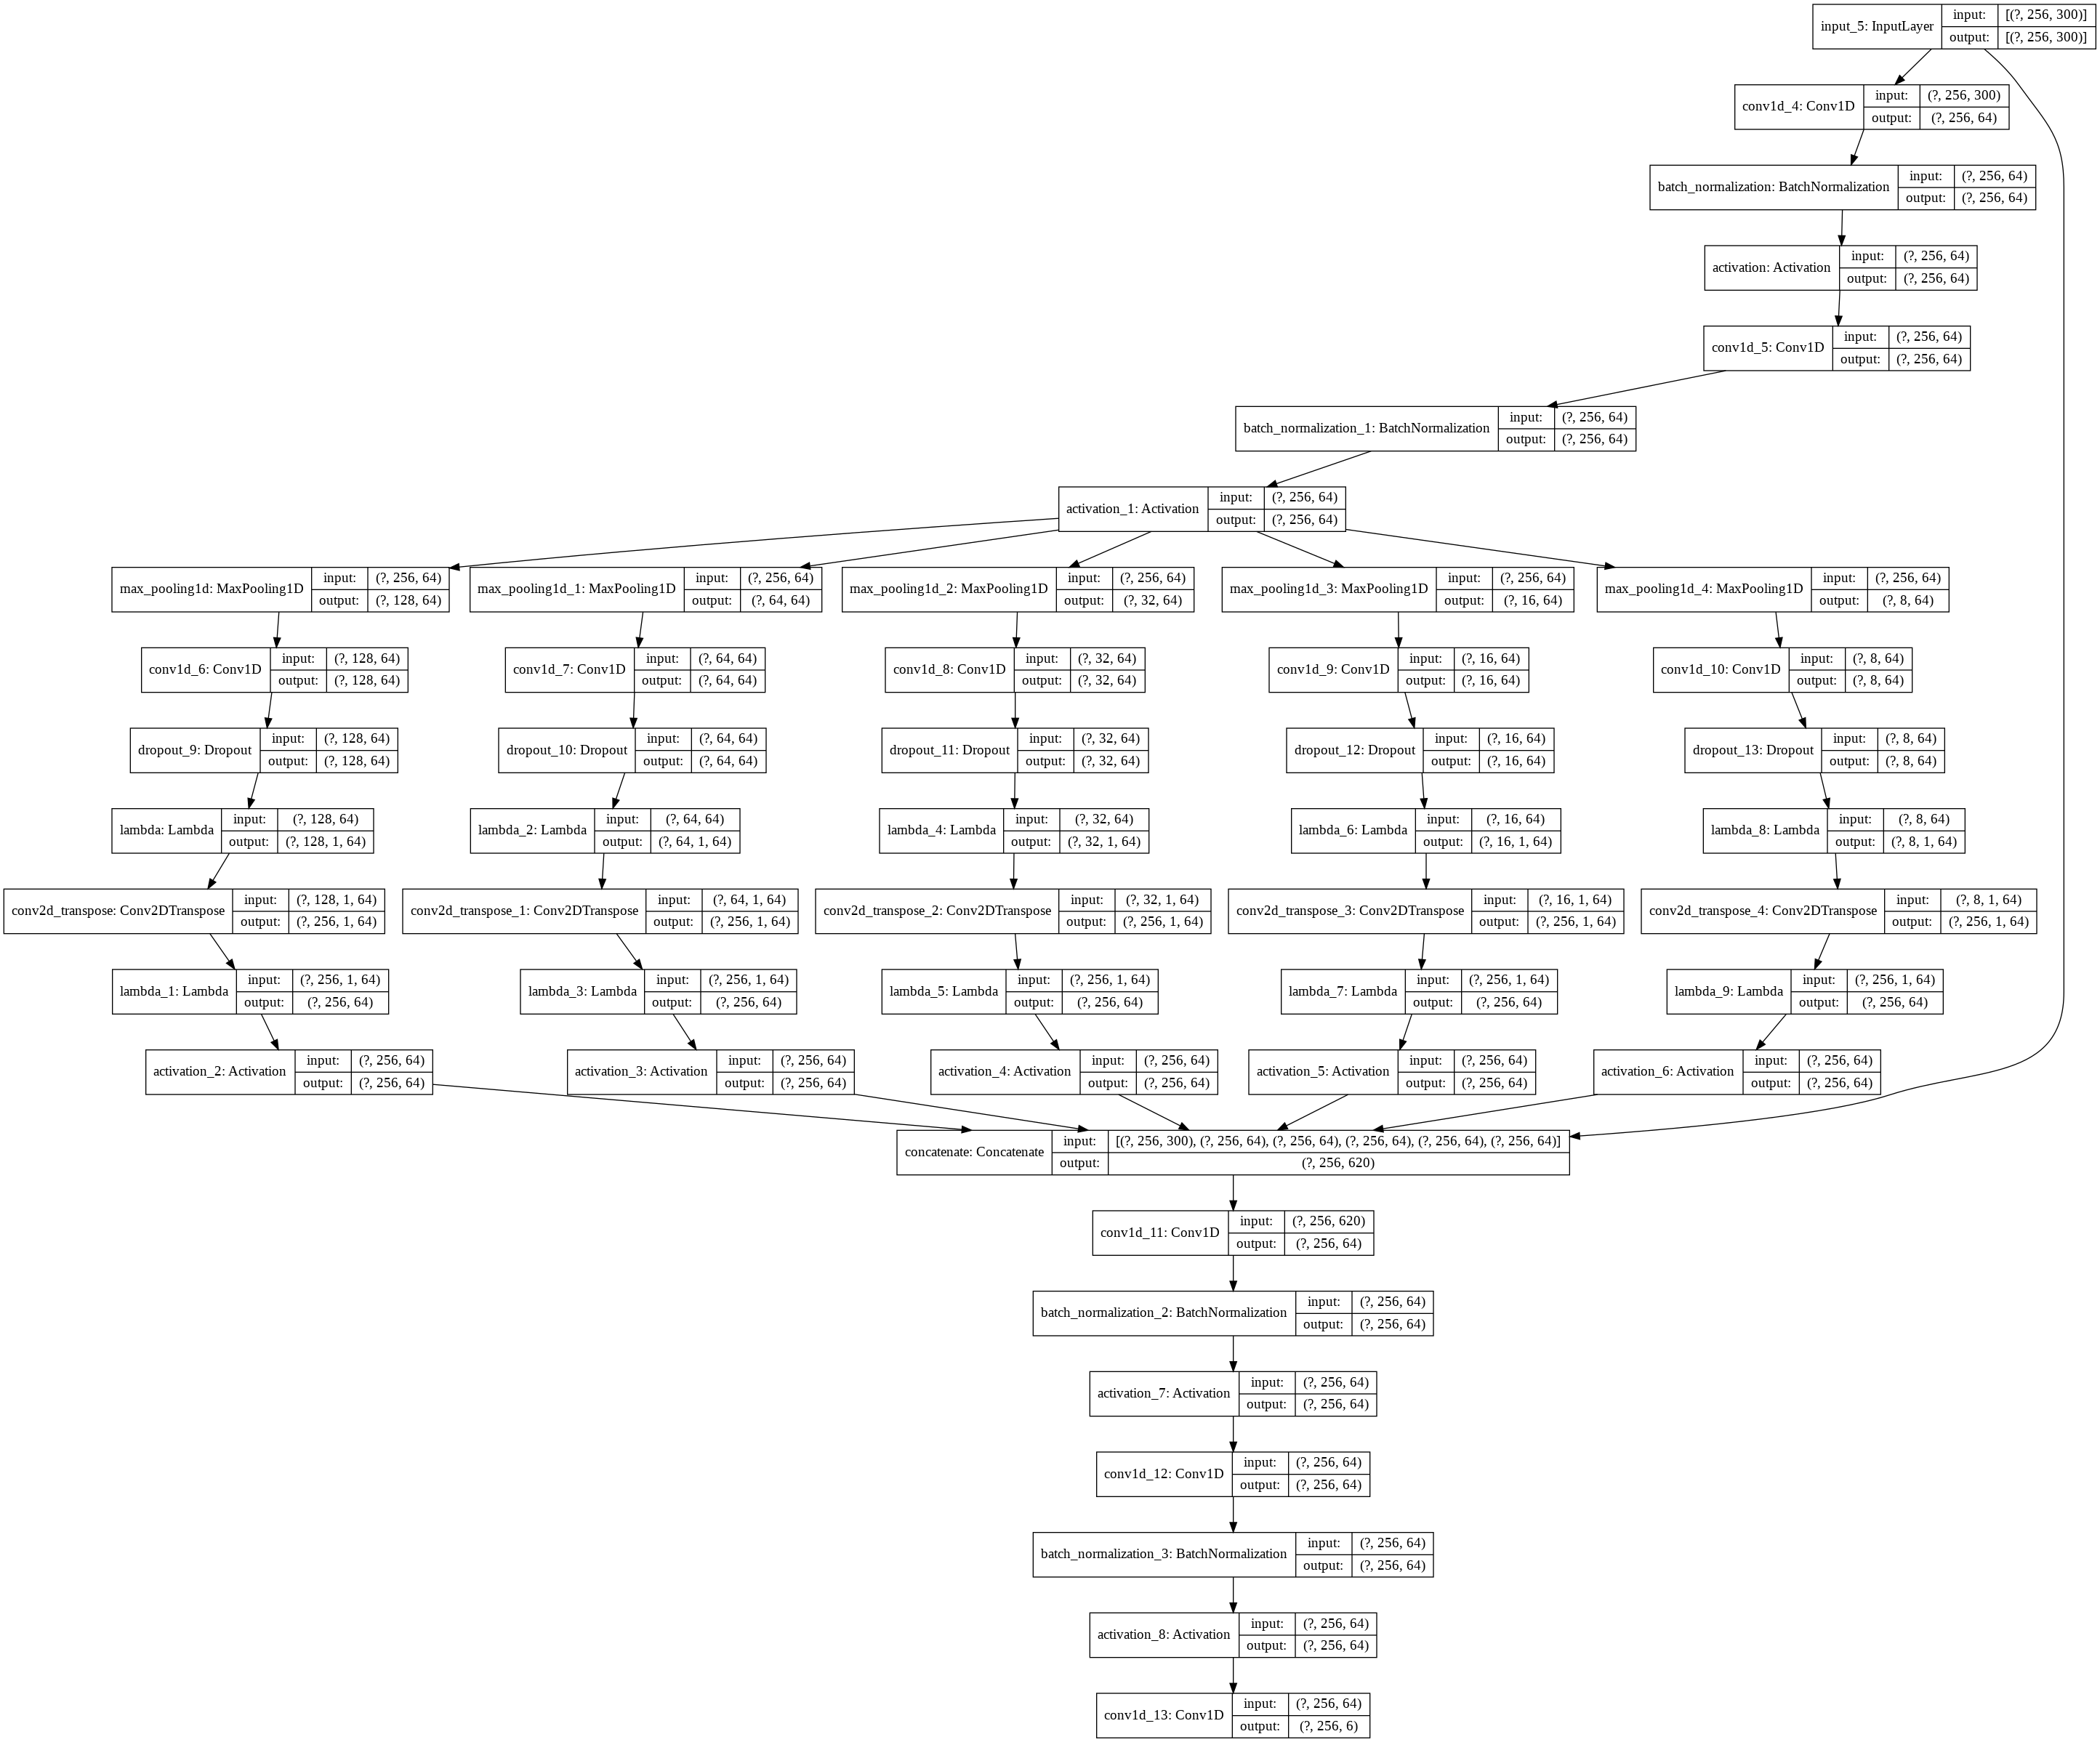

In [ ]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
plot_model(model_b_PSPnet, to_file='model_b_PSPnet.png', show_shapes=True) # построим график для визуализации слоев и связей между ними

In [ ]:
history = model_b_PSPnet.fit(xTrainGENSIM, yTrainGENSIM, epochs=25, batch_size=64, validation_split = 0.2)

Epoch 1/25
162/162 [==============================] - 6s 39ms/step - loss: 1.2311 - dice_coef: 0.5395 - val_loss: 1.2569 - val_dice_coef: 0.5252
Epoch 2/25
162/162 [==============================] - 5s 32ms/step - loss: 1.2214 - dice_coef: 0.5419 - val_loss: 1.2200 - val_dice_coef: 0.5416
Epoch 3/25
162/162 [==============================] - 5s 32ms/step - loss: 1.2115 - dice_coef: 0.5447 - val_loss: 1.2041 - val_dice_coef: 0.5476
Epoch 4/25
162/162 [==============================] - 5s 32ms/step - loss: 1.2014 - dice_coef: 0.5476 - val_loss: 1.1929 - val_dice_coef: 0.5512
Epoch 5/25
162/162 [==============================] - 5s 32ms/step - loss: 1.1912 - dice_coef: 0.5506 - val_loss: 1.1825 - val_dice_coef: 0.5544
Epoch 6/25
162/162 [==============================] - 5s 32ms/step - loss: 1.1810 - dice_coef: 0.5538 - val_loss: 1.1723 - val_dice_coef: 0.5576
Epoch 7/25
162/162 [==============================] - 5s 32ms/step - loss: 1.1708 - dice_coef: 0.5571 - val_loss: 1.1623 - val_dic

##### U-net

In [ ]:
#Функция для создания сети UNET 
def create_unet(k=1, num_classes=6, input_shape=(None, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape) 

    # Block 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    x = MaxPooling1D()(block_1_out)

    # Block 2
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling1D()(block_2_out)

    # Block 3
    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # x = block_3_out
    x = MaxPooling1D()(block_3_out)

    # Block 4
    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(x, 256, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(x, 128, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(x, 64, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

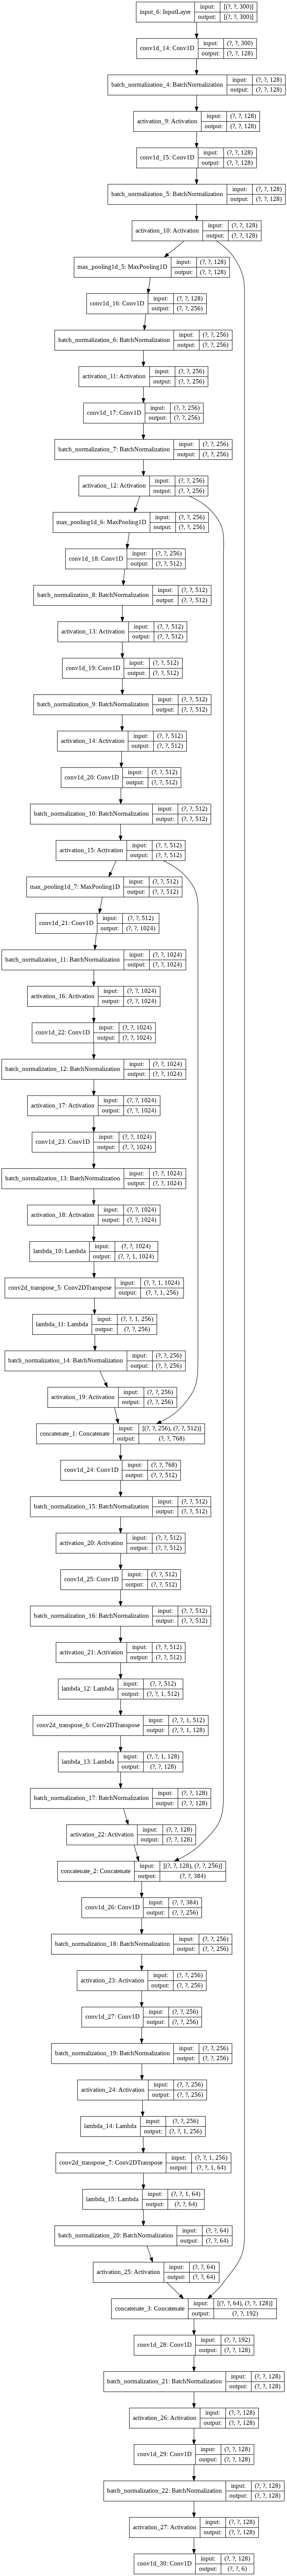

In [ ]:
model_b_UNET = create_unet(k=2, input_shape=(None, embeddingSize))
plot_model(model_b_UNET, to_file='model_b_UNET.png', show_shapes=True) # построим график для визуализации слоев и связей между ними


In [ ]:
lh = LearnHistory()

Epoch 1/25
162/162 [==============================] - 22s 138ms/step - loss: 0.5319 - dice_coef: 0.8230 - val_loss: 1.1268 - val_dice_coef: 0.8241
Epoch 2/25
162/162 [==============================] - 22s 134ms/step - loss: 0.3236 - dice_coef: 0.8838 - val_loss: 0.8988 - val_dice_coef: 0.8629
Epoch 3/25
162/162 [==============================] - 22s 133ms/step - loss: 0.2557 - dice_coef: 0.9020 - val_loss: 0.7609 - val_dice_coef: 0.8576
Epoch 4/25
162/162 [==============================] - 22s 133ms/step - loss: 0.2327 - dice_coef: 0.9092 - val_loss: 2.4780 - val_dice_coef: 0.8089
Epoch 5/25
162/162 [==============================] - 22s 134ms/step - loss: 0.2287 - dice_coef: 0.9113 - val_loss: 0.7848 - val_dice_coef: 0.8427
Epoch 6/25
162/162 [==============================] - 22s 134ms/step - loss: 0.2177 - dice_coef: 0.9169 - val_loss: 0.9074 - val_dice_coef: 0.8560
Epoch 7/25
162/162 [==============================] - 22s 133ms/step - loss: 0.2139 - dice_coef: 0.9193 - val_loss: 0.

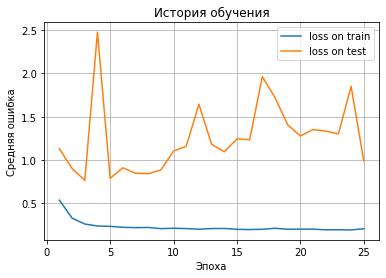

In [ ]:
history = model_b_UNET.fit(xTrainGENSIM, yTrainGENSIM, epochs=25, batch_size=64, validation_split = 0.2)
lh.append(history)
lh.plot()

##### Протестируем сети

In [ ]:
model = model_conv1d 

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
tok_agreemTest = tokenizer.texts_to_sequences(wordsToTest)
xDataTest, yDataTest = get01XSamples(tok_agreemTest,tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xDataTest)
xTest = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTest = getSetFromIndexes(yDataTest, xLen, step)
modelGENSIM = word2vec.Word2Vec(xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)
xTestGENSIM, yTestGENSIM = getSets(modelGENSIM, xTest, yTest)
pred = model.predict(xTestGENSIM)
recognizeSet(yTestGENSIM, pred, xLen, 0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Сеть распознала категорию 'S1' на 61.69%
Сеть распознала категорию 'S2' на 98.02%
Сеть распознала категорию 'S3' на 84.28%
Сеть распознала категорию 'S4' на 87.22%
Сеть распознала категорию 'S5' на 95.31%
Сеть распознала категорию 'S6' на 99.19%
Cредняя точность 87.62%


In [ ]:
model = model_b_PSPnet 

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
tok_agreemTest = tokenizer.texts_to_sequences(wordsToTest)
xDataTest, yDataTest = get01XSamples(tok_agreemTest,tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xDataTest)
xTest = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTest = getSetFromIndexes(yDataTest, xLen, step)
modelGENSIM = word2vec.Word2Vec(xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)
xTestGENSIM, yTestGENSIM = getSets(modelGENSIM, xTest, yTest)
pred = model.predict(xTestGENSIM)
recognizeSet(yTestGENSIM, pred, xLen, 0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Сеть распознала категорию 'S1' на 61.69%
Сеть распознала категорию 'S2' на 98.02%
Сеть распознала категорию 'S3' на 84.28%
Сеть распознала категорию 'S4' на 87.22%
Сеть распознала категорию 'S5' на 95.31%
Сеть распознала категорию 'S6' на 99.19%
Cредняя точность 87.62%


In [ ]:
model = model_b_UNET 

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
tok_agreemTest = tokenizer.texts_to_sequences(wordsToTest)
xDataTest, yDataTest = get01XSamples(tok_agreemTest,tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xDataTest)
xTest = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTest = getSetFromIndexes(yDataTest, xLen, step)
modelGENSIM = word2vec.Word2Vec(xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)
xTestGENSIM, yTestGENSIM = getSets(modelGENSIM, xTest, yTest)
pred = model.predict(xTestGENSIM)
recognizeSet(yTestGENSIM, pred, xLen, 0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Сеть распознала категорию 'S1' на 40.33%
Сеть распознала категорию 'S2' на 98.02%
Сеть распознала категорию 'S3' на 84.42%
Сеть распознала категорию 'S4' на 85.23%
Сеть распознала категорию 'S5' на 91.14%
Сеть распознала категорию 'S6' на 99.19%
Cредняя точность 83.05%


**Итоги:**

**Conv1D:** Cредняя точность 87.62%

**PSPnet:** Cредняя точность 87.62%

**U-net:** Cредняя точность 83.05%

 Conv1D и PSPnet показали одинаковую точность распознования. Поэтому в качестве лучшей возьмем одну из них.
 



**Возьмём в качестве “лучшей” архитектуры PSPnet** 

1. Попробуем видоизменить архитектуру 

Соберем модель, состоящую из слоя эмбеддинга и готовой модели PSPnet:

In [ ]:
inp = Input(shape=(xLen))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])

lh = LearnHistory()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 256, 300)          1687800   
_________________________________________________________________
functional_15 (Functional)   (None, 256, 6)            6895622   
Total params: 8,583,422
Trainable params: 8,581,374
Non-trainable params: 2,048
_________________________________________________________________


Epoch 1/10
1166/1166 [==============================] - 44s 38ms/step - loss: 0.1776 - dice_coef: 0.8973 - val_loss: 0.2976 - val_dice_coef: 0.8988
Epoch 2/10
1166/1166 [==============================] - 43s 37ms/step - loss: 0.0831 - dice_coef: 0.9535 - val_loss: 0.2579 - val_dice_coef: 0.9193
Epoch 3/10
1166/1166 [==============================] - 43s 37ms/step - loss: 0.0524 - dice_coef: 0.9708 - val_loss: 0.2972 - val_dice_coef: 0.9241
Epoch 4/10
1166/1166 [==============================] - 44s 38ms/step - loss: 0.0362 - dice_coef: 0.9798 - val_loss: 0.3573 - val_dice_coef: 0.9267
Epoch 5/10
1166/1166 [==============================] - 44s 37ms/step - loss: 0.0275 - dice_coef: 0.9847 - val_loss: 0.4132 - val_dice_coef: 0.9256
Epoch 6/10
1166/1166 [==============================] - 44s 37ms/step - loss: 0.0220 - dice_coef: 0.9877 - val_loss: 0.4341 - val_dice_coef: 0.9290
Epoch 7/10
1166/1166 [==============================] - 44s 37ms/step - loss: 0.0184 - dice_coef: 0.9897 - val_l

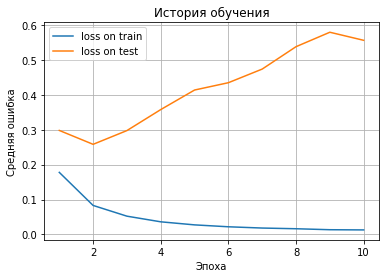

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
score = model.evaluate(x_test, y_test)
score

37/37 [==============================] - 1s 23ms/step - loss: 0.6999 - dice_coef: 0.9168


[0.6998952627182007, 0.9167795777320862]

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.9)

Сеть распознала категорию 'S1' на 76.53%
Сеть распознала категорию 'S2' на 98.25%
Сеть распознала категорию 'S3' на 89.93%
Сеть распознала категорию 'S4' на 90.44%
Сеть распознала категорию 'S5' на 96.59%
Сеть распознала категорию 'S6' на 99.40%
Cредняя точность 91.86%


2. Проверим, как влияет размер batch_size на процент распознавания 

Epoch 1/10
2219/2219 [==============================] - 103s 46ms/step - loss: 0.2546 - dice_coef: 0.8459 - val_loss: 0.3082 - val_dice_coef: 0.8665
Epoch 2/10
2219/2219 [==============================] - 102s 46ms/step - loss: 0.1383 - dice_coef: 0.9192 - val_loss: 0.3643 - val_dice_coef: 0.8757
Epoch 3/10
2219/2219 [==============================] - 101s 46ms/step - loss: 0.0889 - dice_coef: 0.9489 - val_loss: 0.4313 - val_dice_coef: 0.8770
Epoch 4/10
2219/2219 [==============================] - 102s 46ms/step - loss: 0.0630 - dice_coef: 0.9644 - val_loss: 0.4582 - val_dice_coef: 0.8785
Epoch 5/10
2219/2219 [==============================] - 101s 46ms/step - loss: 0.0476 - dice_coef: 0.9733 - val_loss: 0.5484 - val_dice_coef: 0.8855
Epoch 6/10
2219/2219 [==============================] - 101s 46ms/step - loss: 0.0377 - dice_coef: 0.9790 - val_loss: 0.6590 - val_dice_coef: 0.8901
Epoch 7/10
2219/2219 [==============================] - 101s 46ms/step - loss: 0.0312 - dice_coef: 0.9826 

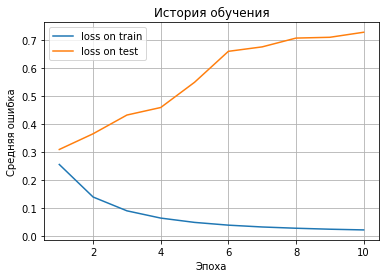

Epoch 1/10
888/888 [==============================] - 65s 73ms/step - loss: 0.2339 - dice_coef: 0.8604 - val_loss: 0.3344 - val_dice_coef: 0.8587
Epoch 2/10
888/888 [==============================] - 64s 73ms/step - loss: 0.1184 - dice_coef: 0.9314 - val_loss: 0.3750 - val_dice_coef: 0.8783
Epoch 3/10
888/888 [==============================] - 65s 73ms/step - loss: 0.0751 - dice_coef: 0.9572 - val_loss: 0.4704 - val_dice_coef: 0.8808
Epoch 4/10
888/888 [==============================] - 64s 73ms/step - loss: 0.0532 - dice_coef: 0.9701 - val_loss: 0.5220 - val_dice_coef: 0.8848
Epoch 5/10
888/888 [==============================] - 65s 73ms/step - loss: 0.0414 - dice_coef: 0.9768 - val_loss: 0.5396 - val_dice_coef: 0.8764
Epoch 6/10
888/888 [==============================] - 65s 73ms/step - loss: 0.0332 - dice_coef: 0.9815 - val_loss: 0.6443 - val_dice_coef: 0.8862
Epoch 7/10
888/888 [==============================] - 65s 73ms/step - loss: 0.0282 - dice_coef: 0.9843 - val_loss: 0.6872 - 

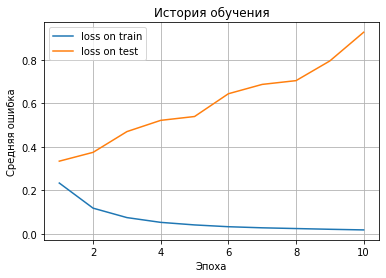

Epoch 1/10
444/444 [==============================] - 54s 121ms/step - loss: 0.2556 - dice_coef: 0.8457 - val_loss: 0.3982 - val_dice_coef: 0.8088
Epoch 2/10
444/444 [==============================] - 53s 119ms/step - loss: 0.1242 - dice_coef: 0.9279 - val_loss: 0.4059 - val_dice_coef: 0.8704
Epoch 3/10
444/444 [==============================] - 53s 119ms/step - loss: 0.0757 - dice_coef: 0.9570 - val_loss: 0.5338 - val_dice_coef: 0.8835
Epoch 4/10
444/444 [==============================] - 53s 118ms/step - loss: 0.0532 - dice_coef: 0.9701 - val_loss: 0.5240 - val_dice_coef: 0.8845
Epoch 5/10
444/444 [==============================] - 53s 119ms/step - loss: 0.0399 - dice_coef: 0.9776 - val_loss: 0.5461 - val_dice_coef: 0.8856
Epoch 6/10
444/444 [==============================] - 53s 119ms/step - loss: 0.0318 - dice_coef: 0.9822 - val_loss: 0.5978 - val_dice_coef: 0.8860
Epoch 7/10
444/444 [==============================] - 52s 118ms/step - loss: 0.0278 - dice_coef: 0.9845 - val_loss: 0.

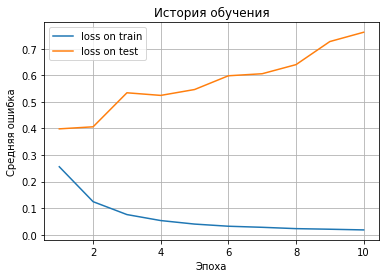

Epoch 1/10
222/222 [==============================] - 48s 216ms/step - loss: 0.2670 - dice_coef: 0.8401 - val_loss: 1.0485 - val_dice_coef: 0.4670
Epoch 2/10
222/222 [==============================] - 47s 211ms/step - loss: 0.1318 - dice_coef: 0.9231 - val_loss: 0.4488 - val_dice_coef: 0.8097
Epoch 3/10
222/222 [==============================] - 47s 210ms/step - loss: 0.0783 - dice_coef: 0.9553 - val_loss: 0.4386 - val_dice_coef: 0.8755
Epoch 4/10
222/222 [==============================] - 47s 211ms/step - loss: 0.0544 - dice_coef: 0.9692 - val_loss: 0.5540 - val_dice_coef: 0.8678
Epoch 5/10
222/222 [==============================] - 47s 211ms/step - loss: 0.0399 - dice_coef: 0.9775 - val_loss: 0.5441 - val_dice_coef: 0.8752
Epoch 6/10
222/222 [==============================] - 47s 211ms/step - loss: 0.0324 - dice_coef: 0.9817 - val_loss: 0.5771 - val_dice_coef: 0.8788
Epoch 7/10
222/222 [==============================] - 47s 211ms/step - loss: 0.0274 - dice_coef: 0.9845 - val_loss: 0.

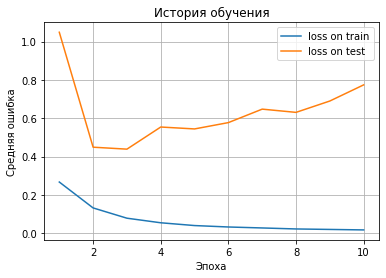

In [ ]:
for b_s in [10, 25, 50, 100]:   
  inp = Input(shape=(xLen))
  x = Embedding(vocSize, embeddingSize)(inp)
  out = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))(x)

  model = Model(inp, out)
  model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
  lh = LearnHistory()

  history = model.fit(x_train, y_train, epochs=10, batch_size=b_s, validation_split=0.2)
  lh.append(history)
  lh.plot()

3. Проверим влиямия параметра conv_size на процент распознования

Epoch 1/10
2219/2219 [==============================] - 82s 37ms/step - loss: 0.2220 - dice_coef: 0.8669 - val_loss: 0.2995 - val_dice_coef: 0.8568
Epoch 2/10
2219/2219 [==============================] - 79s 36ms/step - loss: 0.1227 - dice_coef: 0.9282 - val_loss: 0.3376 - val_dice_coef: 0.8672
Epoch 3/10
2219/2219 [==============================] - 79s 36ms/step - loss: 0.0849 - dice_coef: 0.9510 - val_loss: 0.3725 - val_dice_coef: 0.8719
Epoch 4/10
2219/2219 [==============================] - 80s 36ms/step - loss: 0.0658 - dice_coef: 0.9625 - val_loss: 0.4513 - val_dice_coef: 0.8806
Epoch 5/10
2219/2219 [==============================] - 80s 36ms/step - loss: 0.0539 - dice_coef: 0.9696 - val_loss: 0.4492 - val_dice_coef: 0.8796
Epoch 6/10
2219/2219 [==============================] - 79s 36ms/step - loss: 0.0468 - dice_coef: 0.9737 - val_loss: 0.4716 - val_dice_coef: 0.8749
Epoch 7/10
2219/2219 [==============================] - 78s 35ms/step - loss: 0.0409 - dice_coef: 0.9770 - val_l

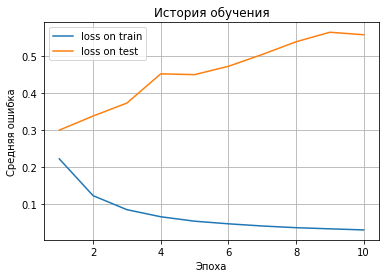

Epoch 1/10
2219/2219 [==============================] - 87s 39ms/step - loss: 0.2333 - dice_coef: 0.8602 - val_loss: 0.2997 - val_dice_coef: 0.8628
Epoch 2/10
2219/2219 [==============================] - 86s 39ms/step - loss: 0.1256 - dice_coef: 0.9269 - val_loss: 0.3631 - val_dice_coef: 0.8760
Epoch 3/10
2219/2219 [==============================] - 86s 39ms/step - loss: 0.0838 - dice_coef: 0.9520 - val_loss: 0.4010 - val_dice_coef: 0.8846
Epoch 4/10
2219/2219 [==============================] - 86s 39ms/step - loss: 0.0629 - dice_coef: 0.9645 - val_loss: 0.5161 - val_dice_coef: 0.8856
Epoch 5/10
2219/2219 [==============================] - 86s 39ms/step - loss: 0.0487 - dice_coef: 0.9726 - val_loss: 0.6132 - val_dice_coef: 0.8835
Epoch 6/10
2219/2219 [==============================] - 87s 39ms/step - loss: 0.0411 - dice_coef: 0.9770 - val_loss: 0.5225 - val_dice_coef: 0.8785
Epoch 7/10
2219/2219 [==============================] - 87s 39ms/step - loss: 0.0349 - dice_coef: 0.9805 - val_l

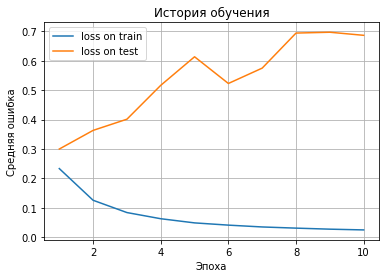

Epoch 1/10
2219/2219 [==============================] - 99s 45ms/step - loss: 0.2415 - dice_coef: 0.8553 - val_loss: 0.3257 - val_dice_coef: 0.8475
Epoch 2/10
2219/2219 [==============================] - 99s 45ms/step - loss: 0.1309 - dice_coef: 0.9235 - val_loss: 0.3881 - val_dice_coef: 0.8812
Epoch 3/10
2219/2219 [==============================] - 100s 45ms/step - loss: 0.0850 - dice_coef: 0.9513 - val_loss: 0.4539 - val_dice_coef: 0.8795
Epoch 4/10
2219/2219 [==============================] - 100s 45ms/step - loss: 0.0593 - dice_coef: 0.9665 - val_loss: 0.5042 - val_dice_coef: 0.8720
Epoch 5/10
2219/2219 [==============================] - 99s 45ms/step - loss: 0.0452 - dice_coef: 0.9748 - val_loss: 0.5626 - val_dice_coef: 0.8708
Epoch 6/10
2219/2219 [==============================] - 100s 45ms/step - loss: 0.0354 - dice_coef: 0.9802 - val_loss: 0.7067 - val_dice_coef: 0.8843
Epoch 7/10
2219/2219 [==============================] - 100s 45ms/step - loss: 0.0294 - dice_coef: 0.9836 - v

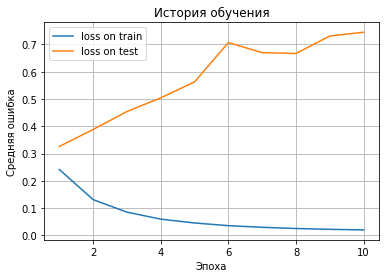

Epoch 1/10
2219/2219 [==============================] - 216s 97ms/step - loss: 0.2684 - dice_coef: 0.8380 - val_loss: 0.3188 - val_dice_coef: 0.8565
Epoch 2/10
2219/2219 [==============================] - 213s 96ms/step - loss: 0.1513 - dice_coef: 0.9113 - val_loss: 0.3714 - val_dice_coef: 0.8692
Epoch 3/10
2219/2219 [==============================] - 212s 96ms/step - loss: 0.0952 - dice_coef: 0.9451 - val_loss: 0.4273 - val_dice_coef: 0.8695
Epoch 4/10
2219/2219 [==============================] - 212s 95ms/step - loss: 0.0644 - dice_coef: 0.9635 - val_loss: 0.4707 - val_dice_coef: 0.8826
Epoch 5/10
2219/2219 [==============================] - 212s 96ms/step - loss: 0.0462 - dice_coef: 0.9742 - val_loss: 0.5653 - val_dice_coef: 0.8848
Epoch 6/10
2219/2219 [==============================] - 213s 96ms/step - loss: 0.0352 - dice_coef: 0.9804 - val_loss: 0.6093 - val_dice_coef: 0.8838
Epoch 7/10
2219/2219 [==============================] - 213s 96ms/step - loss: 0.0283 - dice_coef: 0.9843 

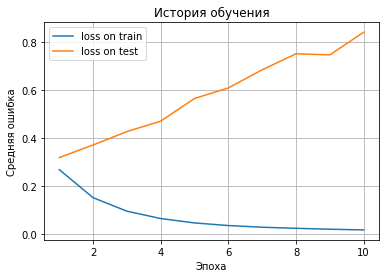

In [ ]:
for c_s in [64, 128, 256, 512]:   
  inp = Input(shape=(xLen))
  x = Embedding(vocSize, embeddingSize)(inp)
  out = create_PSPNet(conv_size=c_s, input_shape=(xLen, embeddingSize))(x)

  model = Model(inp, out)
  model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
  lh = LearnHistory()

  history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.2)
  lh.append(history)
  lh.plot()

#### **3.Напишите ваши выводы**

1. Модель, состоящая из слоя эмбеддинга и готовой модели PSPnet показала среднюю точность 91.86% в то время как сама сеть PSPnet дала 87.62% точности, из чего можно сделать вывод что добавление слоя эмбеддинга явно пошло на пользу и улучшило работу сети.

2. Проведя ряд экспереместов с размером batch_size, можно сделать вывод что его размер практически не влияет на точность распознования (все 4 проведенных эксперемента показали практически одинаковую точность).

3. При validation_split=0.2 точность распознования меньше чем при validation_split=0.1

4. Эксперементируя с размером conv_size, максимального val_dice_coef = 0.8904 удалось добиться при conv_size = 256, из чего делаем вывод, что оптимальное количество фильтров сверточного слоя для данной сети = 256.




## **PRO**

### Вариант 2

**Задание:**

Реализуйте сегментацию на расширенной выборке договоров и добейтесь точности не менее 88%.



In [ ]:
%%time
directory = '/content/drive/My Drive/Colab Notebooks/Базы/Договора1000/'
agreements = [] # Список, в который запишем все наши договоры
for filename in os.listdir(directory): # Проходим по всем файлам в директории договоров
    txt = readText(directory + filename) # Читаем текст договора
    if txt != '': # Если текст не пустой
        agreements.append(readText(directory + filename))
words = [] # Здесь будут храниться все договора в виде списка слов
print("Токенизация...")
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): # Проходимся по всем договорам
    words.append(text2Words(agreements[i])) # Преобразуем очередной договор в список слов и добавляем в words
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

random.shuffle(words)
wordsToTest = words[-30:] # Возьмем 30 текстов для финальной проверки обученной нейронной сети 
words = words[:-30] 

tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer.word_index.items(): #Преобразуем полученный список 
    clean_voc[item[0]] = item[1]

tok_agreem = tokenizer.texts_to_sequences(words)

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

xData, yData = get01XSamples(tok_agreem, tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300

xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов


Токенизация...
На преобразование ушло: 295.98 с.
Индексы тегов: [ 12 402  26  28 128 262  14 411  30  36 144 284]
CPU times: user 4min 48s, sys: 14 s, total: 5min 2s
Wall time: 8min 49s


In [ ]:
# Проверка что число открывающихся тэгов равно числу закрывающихся.
counts = {}
for con in tok_agreem:
    for i in con:
        if i in tags_index:
            tag = tokenizer.index_word[i]
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1

for i in range(1, 7):
    print ("<s%d>: %d, </s%d>: %d" % (i, counts['<s%d>' % i], i , counts['</s%d>' % i]))

<s1>: 8601, </s1>: 7907
<s2>: 350, </s2>: 343
<s3>: 4117, </s3>: 3802
<s4>: 3908, </s4>: 3493
<s5>: 1242, </s5>: 1112
<s6>: 618, </s6>: 568


Заметна нехватка открывающих тегов у s2 и явная нехватка закрывающих тегов у всех остальных тегов. 

In [ ]:
xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
# pageSize = xLen
num_classes = 6
vocSize = len(tokenizer.index_word.items()) + 1
print(vocSize)

x_train = np.array(getSetFromIndexes(xData, xLen, step))
y_train = np.array(getSetFromIndexes(yData, xLen, step))
x_train.shape, y_train.shape

8945


((27575, 256), (27575, 256, 6))

Воспользуемся моделью показавшей отличный результат в задании Light - состоящую из слоя эмбеддинга и готовой модели PSPnet

In [ ]:
inp = Input(shape=(xLen))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()
lh = LearnHistory()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 300)          2683500   
_________________________________________________________________
functional_5 (Functional)    (None, 256, 6)            6895622   
Total params: 9,579,122
Trainable params: 9,577,074
Non-trainable params: 2,048
_________________________________________________________________


Epoch 1/10
1931/1931 [==============================] - 90s 47ms/step - loss: 0.2620 - dice_coef: 0.8409 - val_loss: 0.3383 - val_dice_coef: 0.8546
Epoch 2/10
1931/1931 [==============================] - 90s 47ms/step - loss: 0.1439 - dice_coef: 0.9158 - val_loss: 0.3818 - val_dice_coef: 0.8609
Epoch 3/10
1931/1931 [==============================] - 90s 46ms/step - loss: 0.0926 - dice_coef: 0.9467 - val_loss: 0.4887 - val_dice_coef: 0.8762
Epoch 4/10
1931/1931 [==============================] - 91s 47ms/step - loss: 0.0644 - dice_coef: 0.9635 - val_loss: 0.5123 - val_dice_coef: 0.8692
Epoch 5/10
1931/1931 [==============================] - 91s 47ms/step - loss: 0.0478 - dice_coef: 0.9731 - val_loss: 0.5365 - val_dice_coef: 0.8764
Epoch 6/10
1931/1931 [==============================] - 89s 46ms/step - loss: 0.0368 - dice_coef: 0.9796 - val_loss: 0.6722 - val_dice_coef: 0.8778
Epoch 7/10
1931/1931 [==============================] - 89s 46ms/step - loss: 0.0295 - dice_coef: 0.9836 - val_l

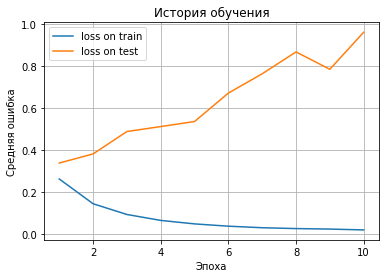

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.3)
lh.append(history)
lh.plot()

In [ ]:
# Подготовим тестовые данные:
tok_agreem2 = tokenizer.texts_to_sequences(wordsToTest)

xData2, yData2 = get01XSamples(tok_agreem2, tags_index)
x_test = np.array(getSetFromIndexes(xData2, xLen, step))
y_test = np.array(getSetFromIndexes(yData2, xLen, step))
x_test.shape, y_test.shape

((1076, 256), (1076, 256, 6))

In [ ]:
score = model.evaluate(x_test, y_test)
score

34/34 [==============================] - 1s 22ms/step - loss: 0.7732 - dice_coef: 0.8904


[0.773162305355072, 0.890376627445221]

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.9)

Сеть распознала категорию 'S1' на 72.41%
Сеть распознала категорию 'S2' на 97.93%
Сеть распознала категорию 'S3' на 83.40%
Сеть распознала категорию 'S4' на 90.89%
Сеть распознала категорию 'S5' на 96.10%
Сеть распознала категорию 'S6' на 98.88%
Cредняя точность 89.94%


#### **Выводы:**
Итоговый результат (Cредняя точность 89.94%) получился неплохим и полностью удовлетворяющим условие задачи ( добейтесь точности не менее 88%).
Даже несмотря на то что проверка показала плохую разметку - сильную нехватку закрывающихся тэгов, что могло привести плохим результатам нейронной сети.

Единственное, что есть вопрос в корректности результатов, так как при плохой разметке велик шанс что yData сформируется неверно, а это может привести к плохим/некорректным результатам работы нейронной сети. В данном случае мы работаем с "тем что есть" и к сожалению повлиять на разметку не можем - только если не переделать её полностью самостоятельно...

В данном задании стояла задача добится точности не менее 88%, именно на этих некорректно сегментированных данных - что было успешно выполнено. **Итоговая точность составила 89.94%.**



## **ULTRA PRO**


### **Задание:** 
Сделайте сегментацию резюме hh или писателей (базы с предыдущих занятий, либо возьмите готовую альтернативную базу), разметку сделать самостоятельно (при отсутствии разметки). 

**Подготовка Базы:**

Для данного занятия я выбрала базу, собранную самостоятельно для одного из прошлых занятий - "Русские исполнители", состоящую из текстов песен различных исполнителей. Так как небыло достаточно времени чтобы проставить теги (сделать разметку) всем исполнителям, я сократило их количество до 5.

Значение тегов:

s1 - Название песни 

s2 - Текст одной конкрктной песни

s3 - Женский вокал

s4 - Мужской вокал

s5 - Исполнитель группа "Кино"

s6 - Исполнитель группа "Кипелов"

s7 - Исполнитель группа "Тату"

s8 - Исполнитель Елена Ваенга

s9 - Исполнитель Надежда Кадышева

In [ ]:
# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные 
  text = f.read() #Записываем прочитанный текст в переменную 
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова

# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = [] # Список для тегов
  indexes = [] # Здесь будут лежать индексы
 
  for agreement in tok_agreem: # Проходимся по каждому договору-списку
    tag_place = [0, 0, 0, 0, 0, 0, 0, 0, 0] # Создаем вектор [0,0,0,0,0,0,0,0,0]
    for ex in agreement: # Проходимся по каждому слову договора
        if ex in tags_index: # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex) # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0: # Проверяем, чтобы тег действительно был
            if place[0][0]<9: # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1    # Поэтому ставим 1
            else: 
              tag_place[place[0][0] - 9] = 0  # Остальные теги закрывающие, так что меняем на ноль
        else:          
          tags01.append(tag_place.copy()) # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном 
          indexes.append(ex) # Докидываем индекс слова в список индексов

  return indexes, tags01

# Получение списка слов из индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x] # Вытаскиваем по каждому ключу в список
  return words # Возвращаем полученный текст

# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длину текста
  index = 0 # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

In [ ]:
# Функция, выводящая точность распознавания каждой категории отдельно
def recognizeSet(tagI, pred, length, value):
  total=0
  tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
  for j in range(9): # общее количество тегов
    correct=0
    for i in range(len(tagI)): # проходимся по каждому списку списка тегов
      for k in range(length): # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int): # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1 
    print("Сеть распознала категорию '%s' на %.2f%%" % (tags[j], 100*correct/(len(tagI)*length)))
    total += 100 * correct / (len(tagI)*length)
  print("Cредняя точность %.2f%%" % (total/9))

In [ ]:
%%time
directory = '/content/drive/My Drive/Colab Notebooks/Базы/Сегментация песен/'
agreements = [] 
for filename in os.listdir(directory): 
    txt = readText(directory + filename) 
    if txt != '': 
        agreements.append(readText(directory + filename))
words = [] 
print("Токенизация...")
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): 
    words.append(text2Words(agreements[i])) 
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

random.shuffle(words)
wordsToTest = words[-30:] # Возьмем 30 текстов для финальной проверки обученной нейронной сети 
words = words[:-30] 

tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer.word_index.items(): #Преобразуем полученный список 
    clean_voc[item[0]] = item[1]

tok_agreem = tokenizer.texts_to_sequences(words)

tags_index = ['<s' + str(i) + '>' for i in range(1, 10)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 10)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

xData, yData = get01XSamples(tok_agreem, tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300

xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов

modelGENSIM = word2vec.Word2Vec(xTrain, size=embeddingSize, window=10, min_count=1, workers=10, iter=10)
xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

Токенизация...
На преобразование ушло: 149.57 с.
Индексы тегов: [ 24  22 169 151 293 152 317 346 312  25  23 171 156 296 154 319 347 316]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 4min 55s, sys: 7.56 s, total: 5min 2s
Wall time: 5min 2s


In [ ]:
# Проверка что число открывающихся тэгов равно числу закрывающихся.
counts = {}
for con in tok_agreem:
    for i in con:
        if i in tags_index:
            tag = tokenizer.index_word[i]
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1

for i in range(1, 10):
    print ("<s%d>: %d, </s%d>: %d" % (i, counts['<s%d>' % i], i , counts['</s%d>' % i]))

<s1>: 3077, </s1>: 3077
<s2>: 3085, </s2>: 3085
<s3>: 744, </s3>: 744
<s4>: 792, </s4>: 792
<s5>: 390, </s5>: 390
<s6>: 792, </s6>: 792
<s7>: 378, </s7>: 378
<s8>: 366, </s8>: 366
<s9>: 378, </s9>: 378


In [ ]:
# Функция для создания PSPnet-сети
def create_PSPNet(conv_size = 64, num_classes = 9, input_shape = (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape)

    # Block 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 4, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 4, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

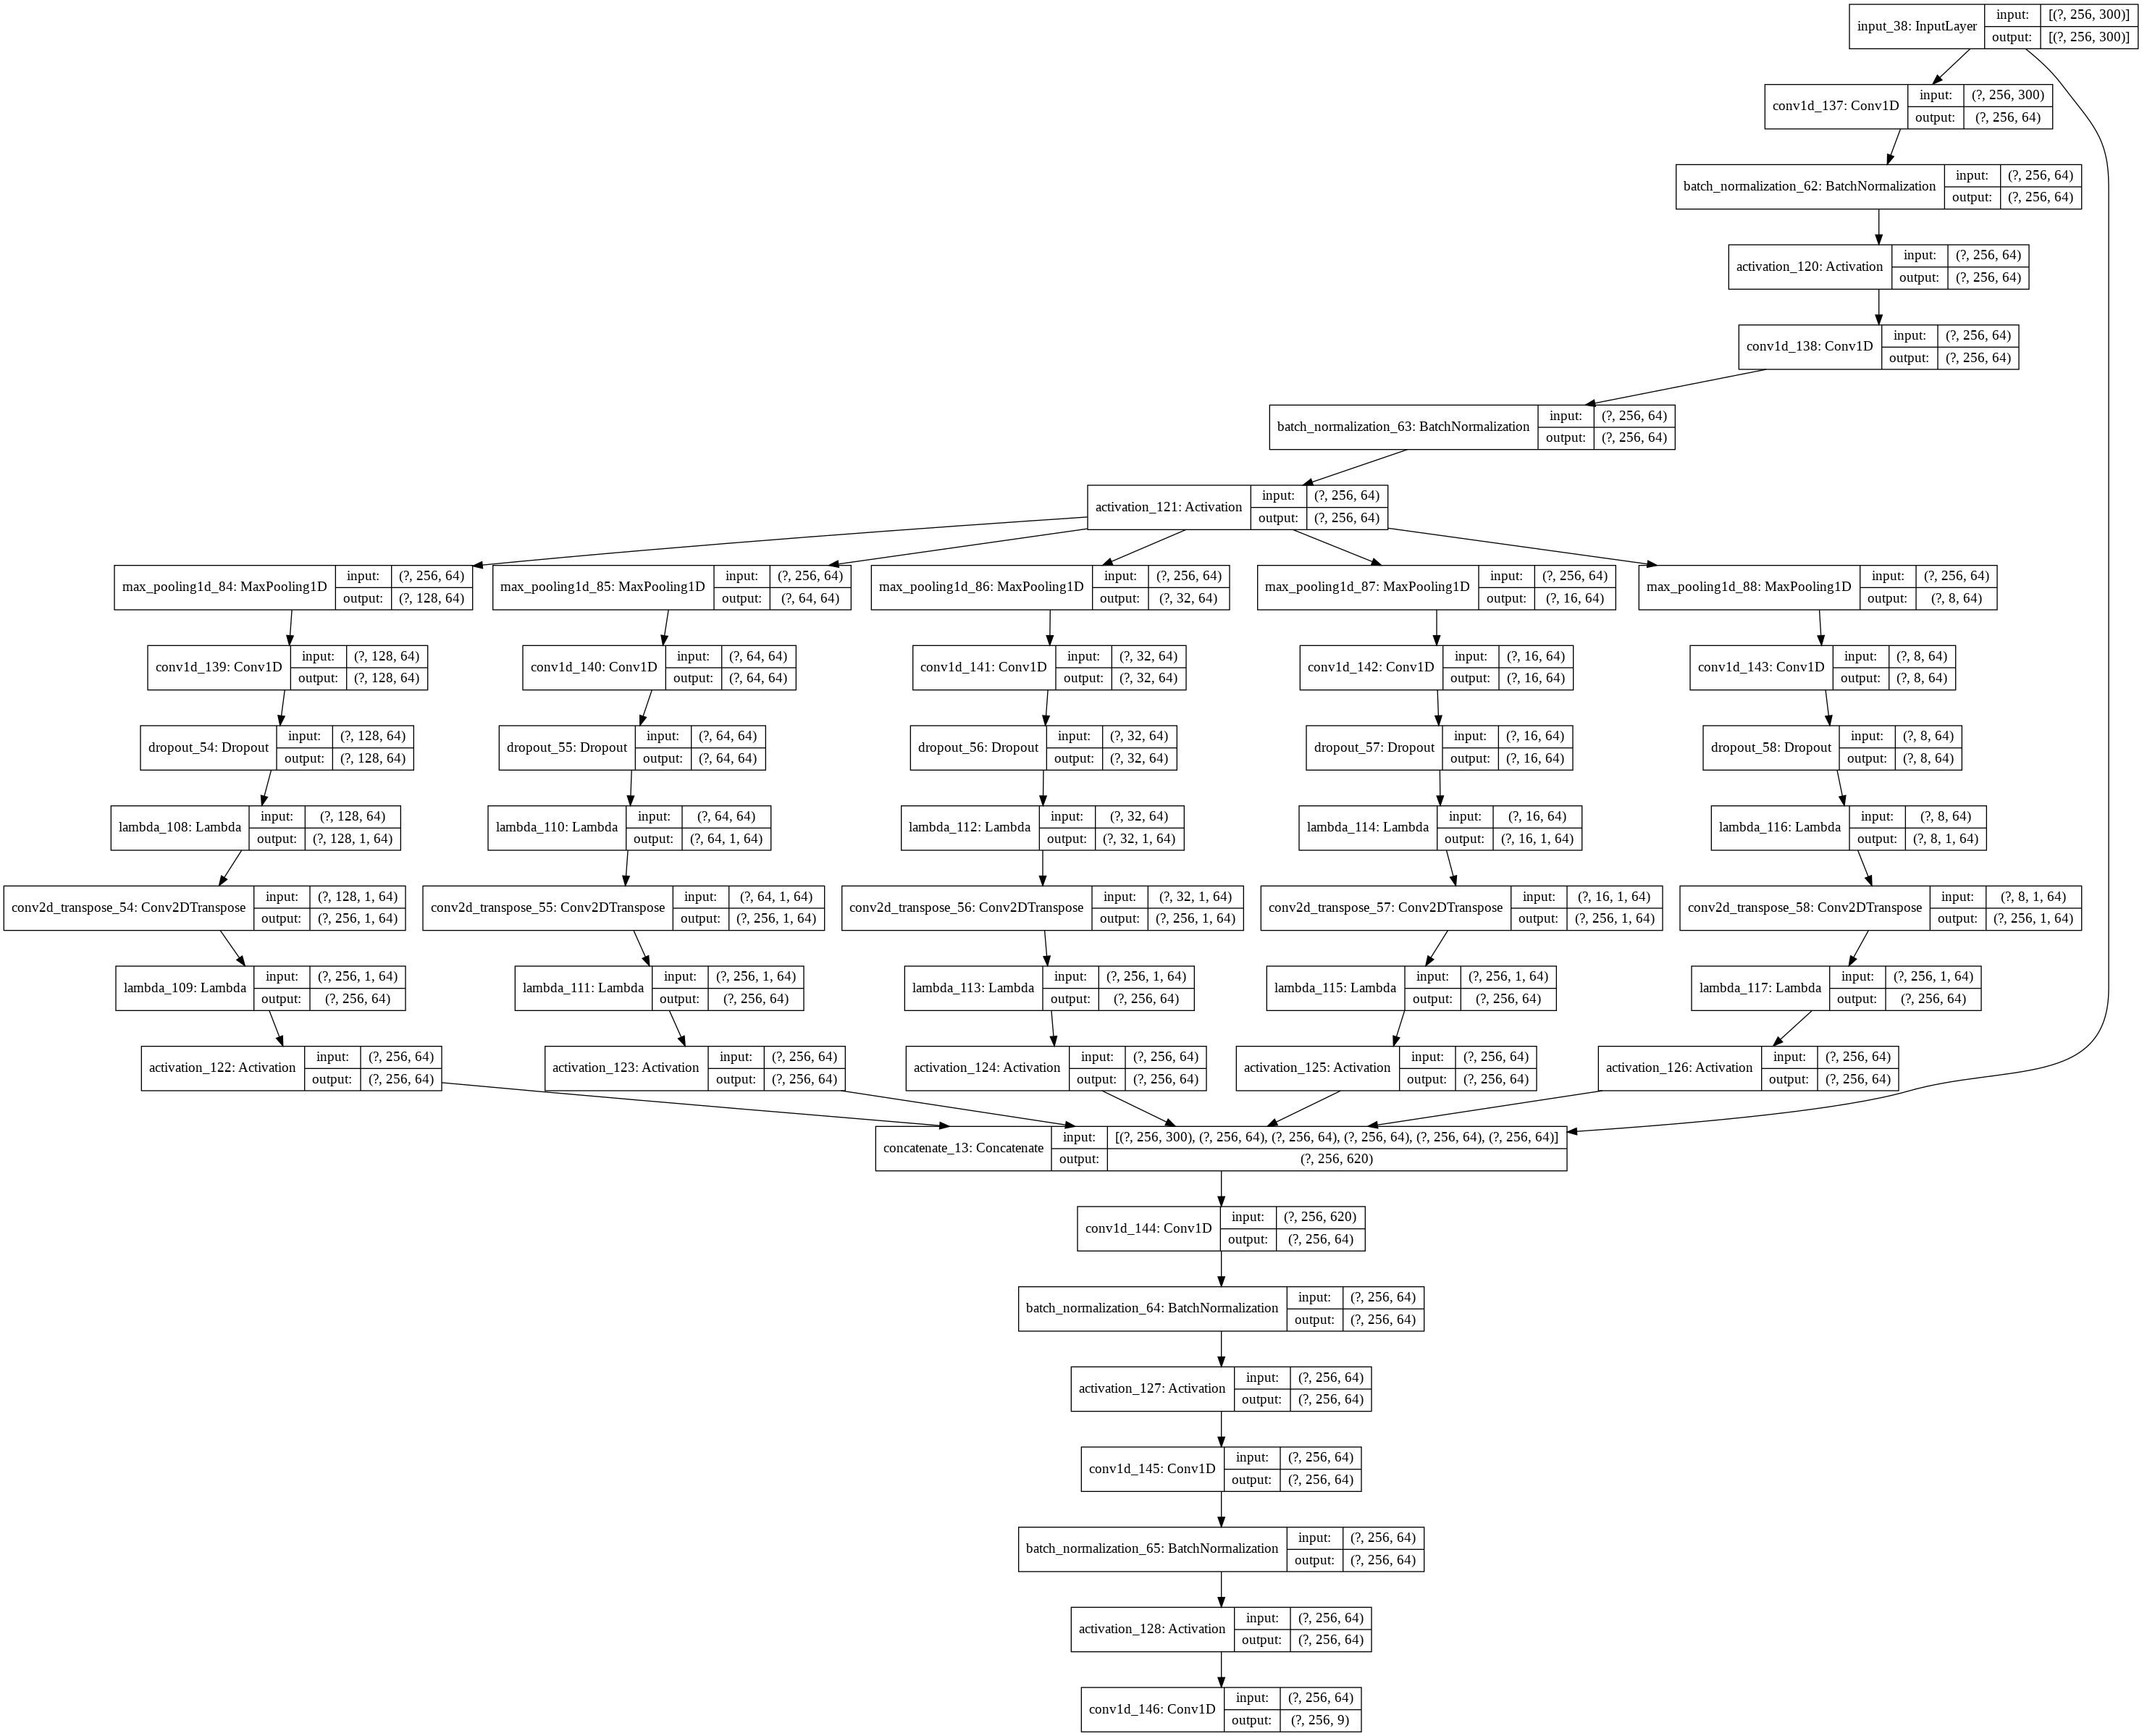

In [ ]:
model_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
plot_model(model_PSPnet, to_file='model_PSPnet.png', show_shapes=True) # построим график для визуализации слоев и связей между ними

In [ ]:
num_classes = 6
vocSize = len(tokenizer.index_word.items()) + 1
print(vocSize)

x_train = np.array(getSetFromIndexes(xData, xLen, step))
y_train = np.array(getSetFromIndexes(yData, xLen, step))
x_train.shape, y_train.shape

758


((16948, 256), (16948, 256, 9))

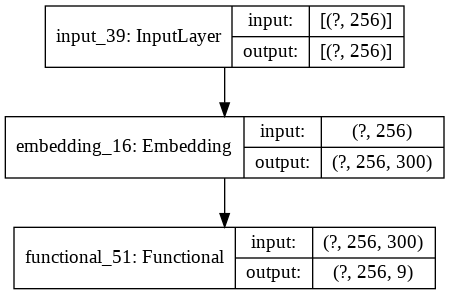

In [ ]:
inp = Input(shape=(xLen))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_PSPNet(conv_size=32, input_shape=(xLen, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.00005), loss='binary_crossentropy', metrics=[dice_coef])

lh = LearnHistory()
plot_model(model_PSPnet_Emb, to_file='model_PSPnet_Emb.png', show_shapes=True)

Epoch 1/15
81/81 [==============================] - 3s 40ms/step - loss: 0.6750 - dice_coef: 0.5372 - val_loss: 0.6748 - val_dice_coef: 0.5111
Epoch 2/15
81/81 [==============================] - 3s 34ms/step - loss: 0.5190 - dice_coef: 0.6157 - val_loss: 0.6207 - val_dice_coef: 0.5552
Epoch 3/15
81/81 [==============================] - 3s 34ms/step - loss: 0.4155 - dice_coef: 0.6758 - val_loss: 0.5773 - val_dice_coef: 0.6097
Epoch 4/15
81/81 [==============================] - 3s 34ms/step - loss: 0.3389 - dice_coef: 0.7243 - val_loss: 0.5525 - val_dice_coef: 0.6455
Epoch 5/15
81/81 [==============================] - 3s 34ms/step - loss: 0.2810 - dice_coef: 0.7640 - val_loss: 0.5234 - val_dice_coef: 0.6676
Epoch 6/15
81/81 [==============================] - 3s 35ms/step - loss: 0.2365 - dice_coef: 0.7965 - val_loss: 0.4540 - val_dice_coef: 0.6922
Epoch 7/15
81/81 [==============================] - 3s 34ms/step - loss: 0.2013 - dice_coef: 0.8235 - val_loss: 0.3370 - val_dice_coef: 0.7370

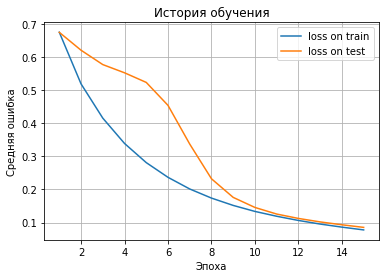

In [ ]:
history = model.fit(x_train, y_train, epochs=15, batch_size=100, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
# Подготовим тестовые данные:
tok_agreem2 = tokenizer.texts_to_sequences(wordsToTest)

xData2, yData2 = get01XSamples(tok_agreem2, tags_index)
x_test = np.array(getSetFromIndexes(xData2, xLen, step))
y_test = np.array(getSetFromIndexes(yData2, xLen, step))
x_test.shape, y_test.shape

((1306, 256), (1306, 256, 9))

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.9)

Сеть распознала категорию 'S1' на 99.28%
Сеть распознала категорию 'S2' на 100.00%
Сеть распознала категорию 'S3' на 98.74%
Сеть распознала категорию 'S4' на 48.41%
Сеть распознала категорию 'S5' на 80.78%
Сеть распознала категорию 'S6' на 78.07%
Сеть распознала категорию 'S7' на 90.26%
Сеть распознала категорию 'S8' на 99.49%
Сеть распознала категорию 'S9' на 97.85%
Cредняя точность 88.10%


**Выводы:**

Процент распознования получился довольно высокий. Что не может не радовать. Данный процент явно связан с тем что разметка была сделана самостоятельно и тщательно, на 100% корректно. Плюс хорошо подобранная архитектура сети, которая точно очень хорошо подходит для подобных задач.
Данное задание было бесценным опытом в разметке текста и подборе хорошей архитектуры! 